In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

GC_WINDOW_SIZE = 100000

## Non-exonic windows, with Gnocchi and GC-content, enhancer-overlap status 

In [3]:
import pandas as pd
from functools import reduce

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )

  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{GC_WINDOW_SIZE}.bed', 
    sep='\t', 
  )
  df2 = df2[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
  df2 = df2.rename(columns={
    'chen_chrom': 'chrom', 
    'chen_start': 'start', 
    'chen_end': 'end',
    'window_GC_content': f'GC_content_{GC_WINDOW_SIZE}bp'
  })

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df3 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df3 = df3[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df3 = df3.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2, df3]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,...,log10_paternal_recombination_rate,log10_maternal_recombination_rate,B_M1star.EUR,B0_M3starHMT6.EUR,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_100000bp,cpg_island_overlap,window_overlaps_cpg_island
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.565094,NaN,False
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.572894,NaN,False
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.572564,NaN,False
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.570774,NaN,False
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.576514,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,...,-1.243724,-1.197675,0.165515,0.135944,3.636507,0.219258,2.281162,0.611944,45.0,True
1019147,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,...,-1.243724,-1.197675,0.165515,0.135944,3.636507,0.219258,2.281162,0.613074,NaN,False
1019148,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,...,-1.243724,-1.197675,0.165515,0.135944,3.636507,0.219258,2.281162,0.613494,NaN,False
1019149,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,...,0.194484,-1.615221,0.165515,0.135944,3.636507,0.219258,2.281162,0.610484,NaN,False


## Baseline classifier

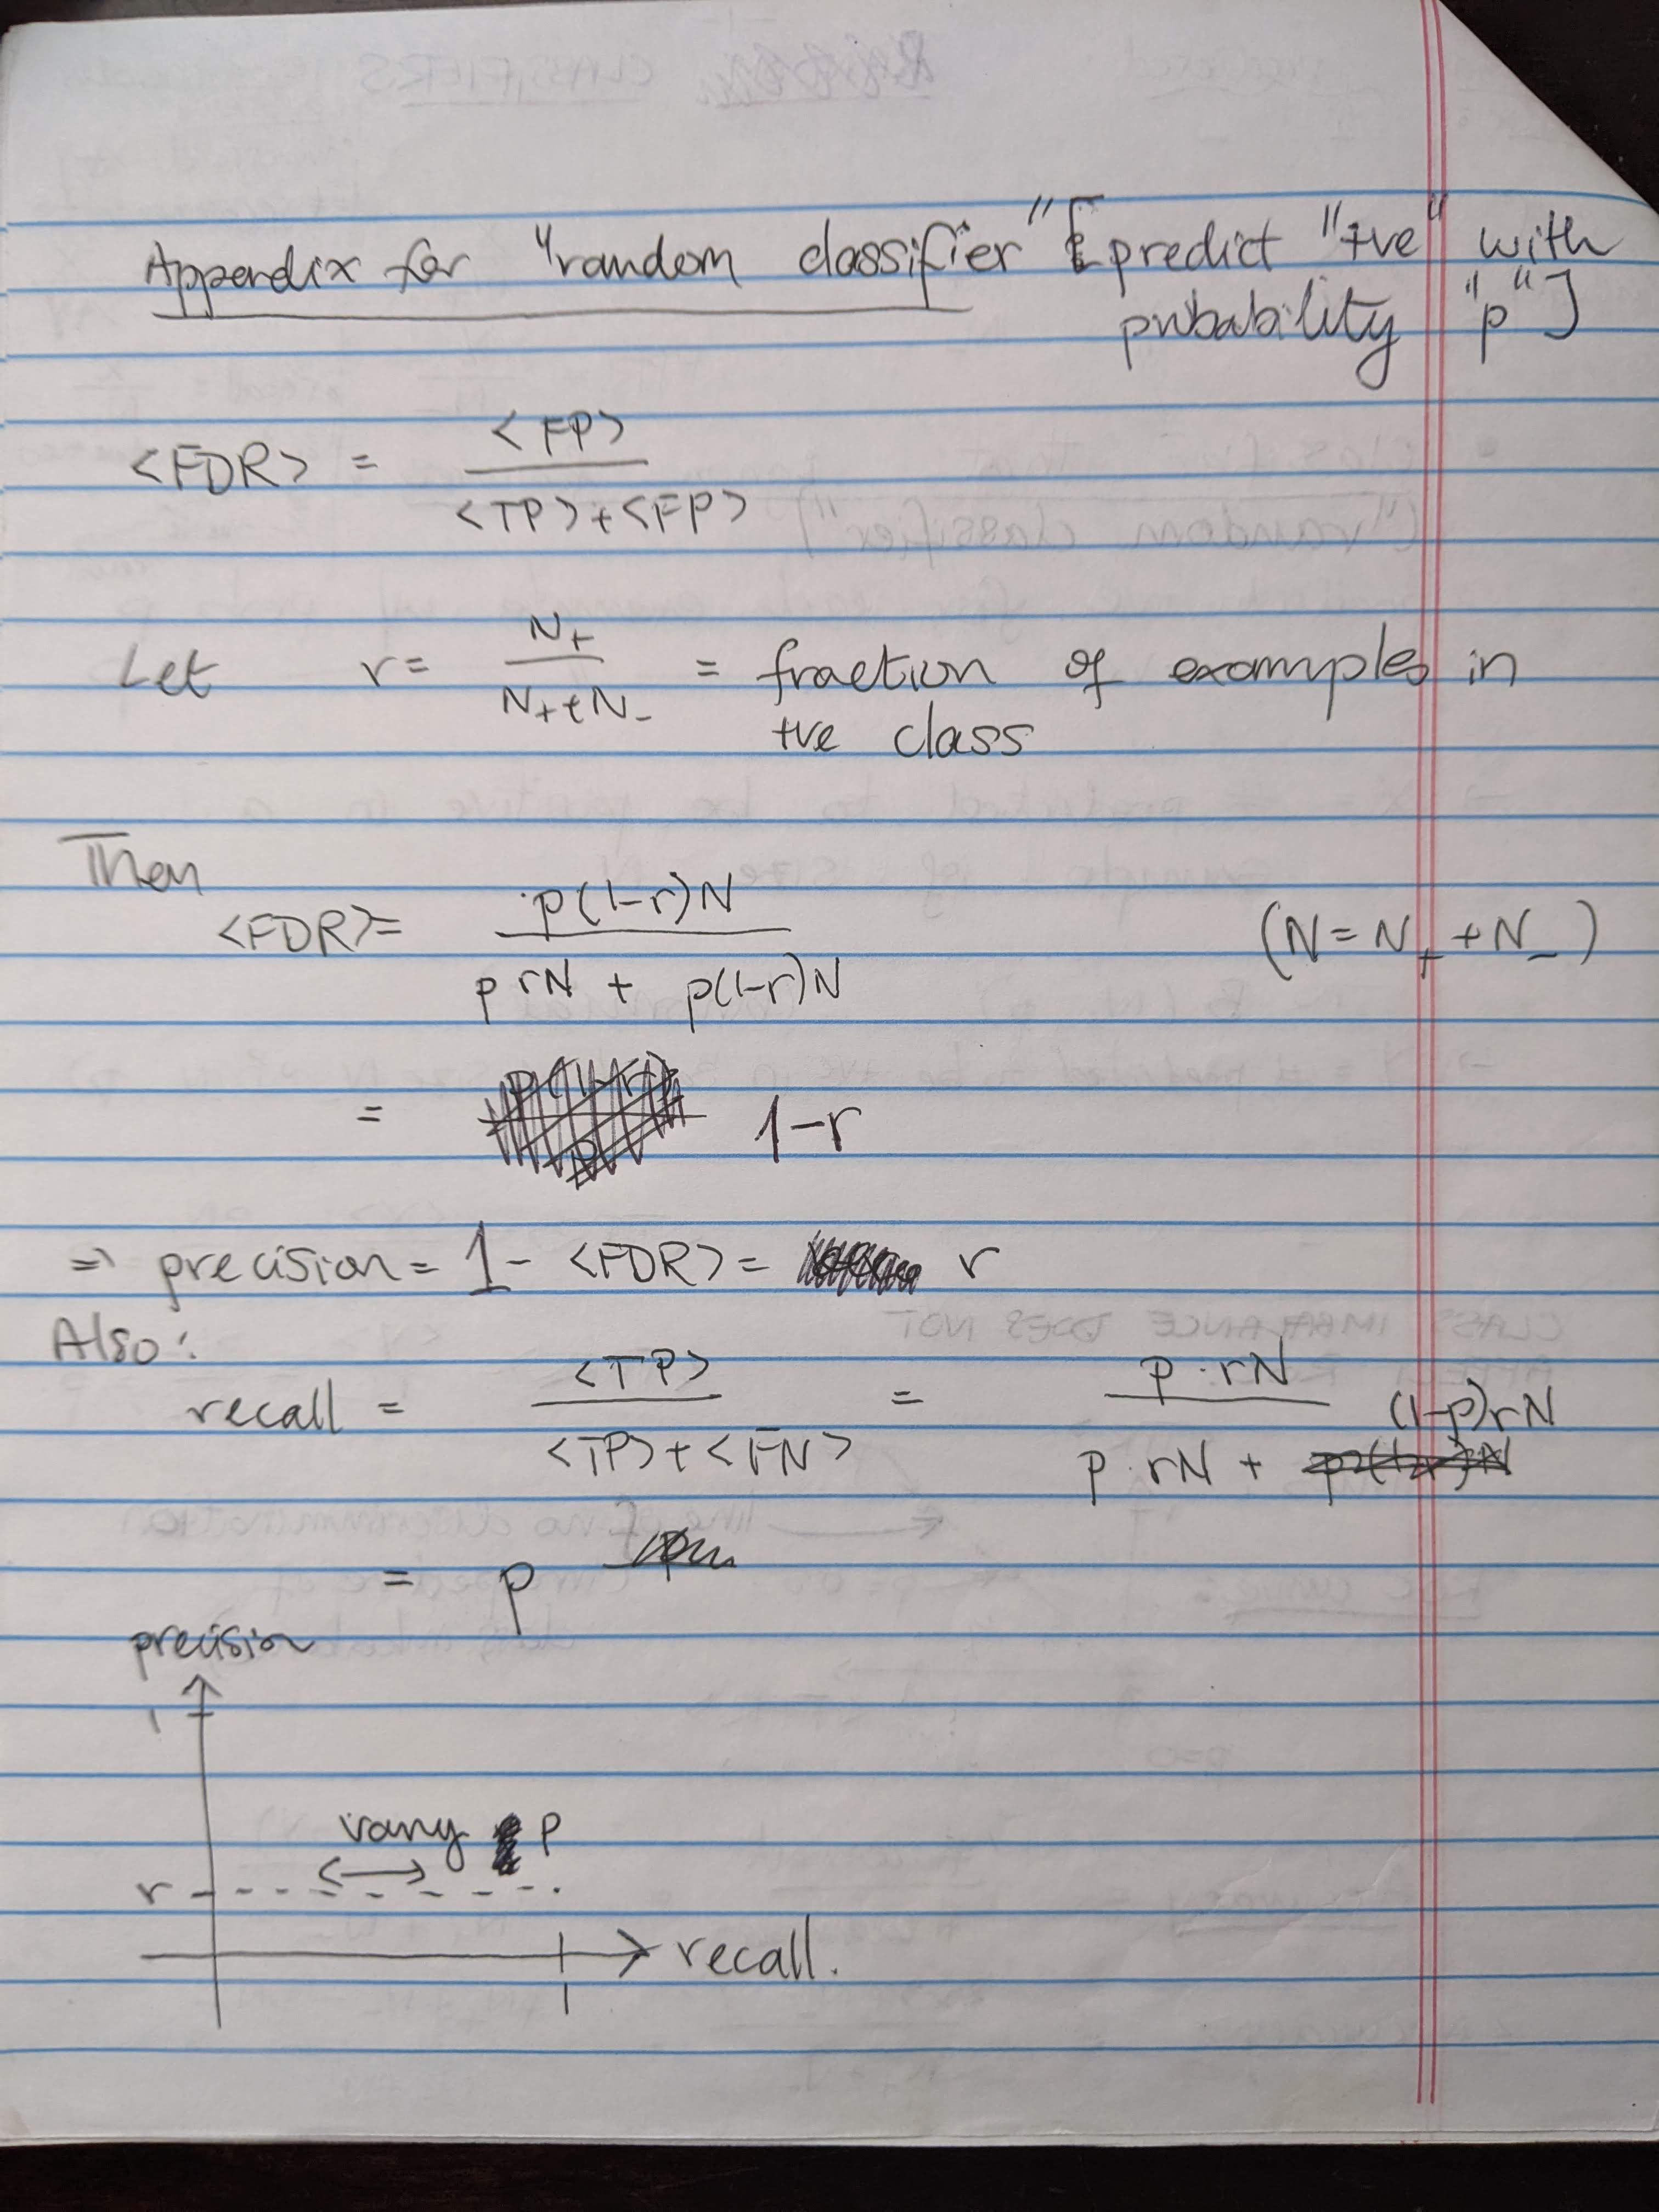

In [8]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## GC-content negatively impacts a Gnocchi-based classifier

ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

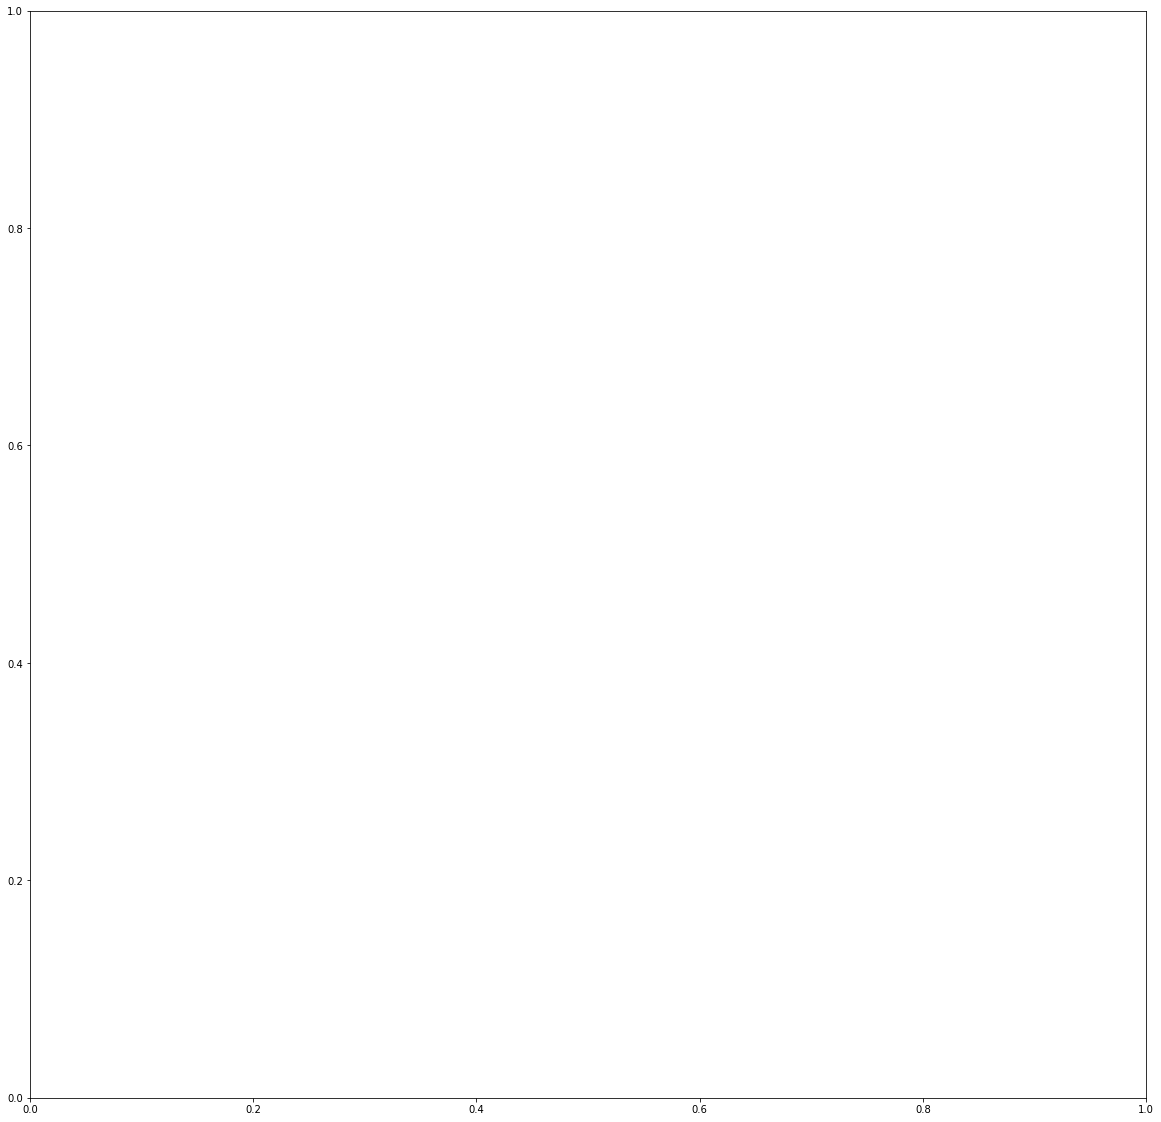

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import auc, precision_recall_curve

def compute_positive_fraction(df, target):
  # this is "r" in the baseline-classifier theory 
  number_negative_examples = df[target].value_counts().loc[False]
  number_positive_examples = df[target].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

def plot_random_classifier(df, target, color, axis):
  r = compute_positive_fraction(df, target)
  axis.plot([0, 1], [r, r], linestyle='--', linewidth=3, color=color, label='random classifier')  

def downsample(df):
  group_columns = [f'GC_content_{GC_WINDOW_SIZE}bp_bin']
  positive_class_sizes = df.groupby(group_columns)['window overlaps enhancer'].apply(lambda ser: ser.value_counts()[True])
  negative_class_sizes = df.groupby(group_columns)['window overlaps enhancer'].apply(lambda ser: ser.value_counts()[False])  
  positive_to_negative_ratios = positive_class_sizes/negative_class_sizes
  min_positive_to_negative_ratio = positive_to_negative_ratios.min()

  def downsample_positive_class(group):
    negative_class = group[group['window overlaps enhancer'] == False]
    negative_class_size = len(negative_class)
    positive_class = group[group['window overlaps enhancer'] == True]
    new_positive_class_size = int(min_positive_to_negative_ratio*negative_class_size)
    positive_class_downsampled = positive_class.sample(new_positive_class_size)
    return pd.concat([positive_class_downsampled, negative_class])
  
  df_downsampled = df.groupby(group_columns).apply(downsample_positive_class).reset_index(drop=True)

  return df_downsampled

def preprocess(df, number_bins): 
  df = df.copy() 
  df[f'GC_content_{GC_WINDOW_SIZE}bp_bin'] = pd.cut(df[f'GC_content_{GC_WINDOW_SIZE}bp'], bins=number_bins) 
  df = downsample(df)
  return df 

def plot_precision_recall_all(df, number_bins, xlim=(0, 1), ylim=(0, 1)): 
  df = preprocess(df, number_bins)

  fig, ax = plt.subplots(figsize=(20, 20))
  cmap = cm.get_cmap('inferno')

  for i, GC_bin in enumerate(sorted(df[f'GC_content_{GC_WINDOW_SIZE}bp_bin'].unique())): 
    df_bin = df[df[f'GC_content_{GC_WINDOW_SIZE}bp'] == GC_bin]
    color = cmap(i / number_bins)
    targets, scores = df_bin['window overlaps enhancer'], df_bin['gnocchi']
    precision, recall, _ = precision_recall_curve(targets, scores)
    plt.plot(recall, precision, color=color, linestyle='-', label=f'GC_content_{GC_WINDOW_SIZE}bp in {GC_bin}')

  plot_random_classifier(
    df, 
    target='window overlaps enhancer', 
    color='black', 
    axis=ax,
  )
  ax.grid(False)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

# TODO: [Monday] continue from here by debugging this function
plot_precision_recall_all(WINDOWS, number_bins=5)

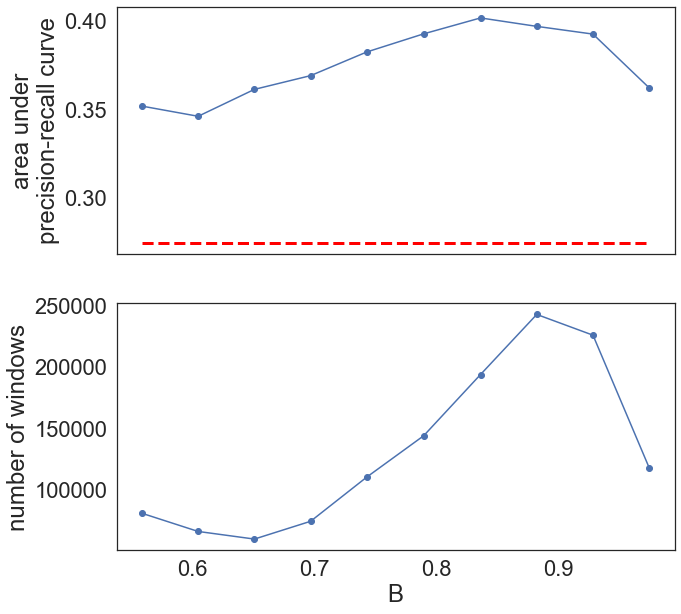

In [25]:
def plot_auPRC_all(df, number_B_bins): 
  df = preprocess(df, number_B_bins)

  Bbin_to_number_windows = df['B_bin'].value_counts()

  b_bin_mids, auPRCs, number_windows = [], [], []
  for b_bin in sorted(df['B_bin'].unique()): 
    df_b_bin = df[df['B_bin'] == b_bin]

    targets, scores = df_b_bin['window overlaps enhancer'], df_b_bin['gnocchi']
    precision, recall, _ = precision_recall_curve(targets, scores)

    b_bin_mids.append(b_bin.mid)
    auPRCs.append(auc(recall, precision))
    number_windows.append(Bbin_to_number_windows.loc[b_bin])

  r = compute_positive_fraction(df, target='window overlaps enhancer')

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

  axs[0].plot(b_bin_mids, auPRCs, marker='o')
  axs[0].plot([min(b_bin_mids), max(b_bin_mids)], [r, r], linestyle='--', linewidth=3, color='red')  
  axs[0].set_ylabel('area under\nprecision-recall curve')
    
  axs[1].plot(b_bin_mids, number_windows, marker='o')
  axs[1].set_xlabel('B')
  axs[1].set_ylabel('number of windows')

plot_auPRC_all(WINDOWS, number_B_bins=10)